## Using The Super Resolution Convolutional Neural Network for Image Restoration


Welcome to this tutorial on single-image super-resolution.  The goal of super-resolution (SR) is to recover a high resolution image from a low resolution input, or as they might say on any modern crime show, **enhance!** 

To accomplish this goal, we will be deploying the super-resolution convolution neural network (SRCNN) using Keras.  This network was published in the paper, "Image Super-Resolution Using Deep Convolutional Networks" by Chao Dong, et al. in 2014.  You can read the full paper at https://arxiv.org/abs/1501.00092.

As the title suggests, the SRCNN is a deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution images.  As a result, we can use it to improve the image quality of low resolution images.  To evaluate the performance of this network, we will be using three image quality metrics: peak signal to noise ratio (PSNR), mean squared error (MSE), and the structural similarity (SSIM) index.  

Furthermore, we will be using OpenCV, the Open Source Computer Vision Library.  OpenCV was originally developed by Intel and is used for many real-time computer vision applications.  In this particular project, we will be using it to pre and post process our images.  As you will see later, we will frequently be converting our images back and forth between the RGB, BGR, and YCrCb color spaces.  This is necessary because the SRCNN network was trained on the luminance (Y) channel in the YCrCb color space.  

During this project, you will learn how to: 

* use the PSNR, MSE, and SSIM image quality metrics,
* process images using OpenCV,
* convert between the RGB, BGR, and YCrCb color spaces,
* build deep neural networks in Keras,
* deploy and evaluate the SRCNN network

### 1. Importing Packages
Let's dive right in! In this first cell, we will import the libraries and packages we will be using in this project and print their version numbers.  This is an important step to make sure we are all on the same page; furthermore, it will help others reproduce the results we obtain. 

In [1]:
# check package versions
import sys
import matplotlib
from multiprocessing import Pool

print('Python: {}'.format(sys.version))
print('Matplotlib: {}'.format(matplotlib.__version__))

Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Matplotlib: 3.2.2


In [2]:
# import the necessary packages
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import clear_session

from skimage.measure import compare_ssim as ssim
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import glob
import cv2
import pandas as pd


# python magic function, displays pyplot figures in the notebook
%matplotlib inline

In [3]:
!git clone https://github.com/0xtaha/image-super-resloution-for-remote-sensing

Cloning into 'image-super-resloution-for-remote-sensing'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (354/354), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 354 (delta 196), reused 217 (delta 93), pack-reused 0
Receiving objects: 100% (354/354), 8.78 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [4]:
!cp -a /content/image-super-resloution-for-remote-sensing/. /content/
!rm -rf /content/image-super-resloution-for-remote-sensing/

## Downloading the Dataset

In [5]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip /content/EuroSAT.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/2750/SeaLake/SeaLake_2206.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1313.jpg  
  inflating: /content/2750/SeaLake/SeaLake_263.jpg  
  inflating: /content/2750/SeaLake/SeaLake_967.jpg  
  inflating: /content/2750/SeaLake/SeaLake_515.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1465.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1817.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2902.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2570.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1004.jpg  
  inflating: /content/2750/SeaLake/SeaLake_174.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2111.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2388.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1948.jpg  
  inflating: /content/2750/SeaLake/SeaLake_838.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2738.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1999.jpg  
  inflating: /content/2750/SeaLake/S

In [6]:
Land_images = glob.glob('/content/2750/**/*.jpg') #returns path of images
print(len(Land_images)) #contains 13243 images

27000


### 2. Image Quality Metrics
To start, lets define a couple of functions that we can use to calculate the PSNR, MSE, and SSIM.  The structural similiarity (SSIM) index was imported directly from the scikit-image library; however, we will have to define our own functions for the PSNR and MSE.  Furthermore, we will wrap all three of these metrics into a single function that we can call later.    

In [7]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


### 3. Preparing Images

For this project, we will be using the same images that were used in the original SRCNN paper.  We can download these images from http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html.  The .zip file identified as the MATLAB code contains the images we want.  Copy both the Set5 and Set14 datasets into a new folder called 'source'. 

Now that we have some images, we want to produce low resolution versions of these same images.  We can accomplish this by resizing the images, both downwards and upwards, using OpeCV. There are several interpolation methods that can be used to resize images; however, we will be using bilinear interpolation.  

Once we produce these low resolution images, we can save them in a new folder.

In [8]:
# prepare degraded images by introducing quality distortions via resizing

from tqdm import tqdm
progress = tqdm(total= len(Land_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(64,64,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, Land_images)


 10%|▉         | 2681/27000 [00:12<00:42, 570.88it/s]

In [9]:
def get_low_res(img , factor):
  # find old and new image dimensions
  h, w, _ = img.shape
  new_height = int(h / factor)
  new_width = int(w / factor)
          
  # resize the image - down
  img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
          
  # resize the image - up
  low_img_resloution = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
  return low_img_resloution


In [10]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2 , train_size = 0.8)

In [11]:
all_images.shape

(27000, 64, 64, 3)

In [12]:
# get low resloution images for training
train_x_low = []

for i in range(train_x.shape[0]):
  temp = get_low_res(train_x[i,:,:,:] , 2)
  train_x_low.append(temp)
train_x_low = np.array(train_x_low)

val_x_low = []

for i in range(val_x.shape[0]):
  temp = get_low_res(val_x[i,:,:,:] , 2)
  val_x_low.append(temp)
val_x_low = np.array(val_x_low)



In [13]:
del all_images
del img_array

In [14]:
import gc
gc.collect()

304

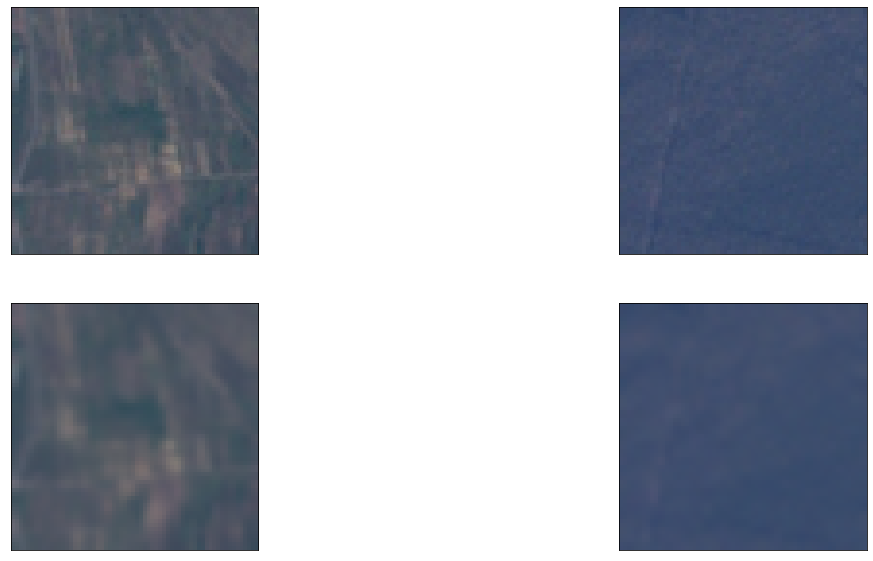

In [15]:
n = 2
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(train_x[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(train_x_low[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### 3. Testing Low Resolution Images

To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded, lets calculate the PSNR, MSE, and SSIM between our reference images and the degraded images that we just prepared.  

In [16]:
# test the generated images using the image quality metrics

for i in range(val_x.shape[0]):
    
    # open target and reference images
    target = val_x_low[i,:,:,:]
    ref = val_x[i,:,:,:]
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(i, scores[0], scores[1], scores[2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Streaming output truncated to the last 5000 lines.
4400
PSNR: 86.54815864260996
MSE: 0.0004319025332420885
SSIM: 0.979176397926921

4401
PSNR: 73.02579946404153
MSE: 0.009719001948254466
SSIM: 0.891769300995184

4402
PSNR: 84.3812331377566
MSE: 0.0007113417545813044
SSIM: 0.9684156675914887

4403
PSNR: 77.48142245563488
MSE: 0.003483849375808253
SSIM: 0.9065886040650786

4404
PSNR: 76.10399940545125
MSE: 0.004784115709599954
SSIM: 0.8829232270093265

4405
PSNR: 72.26199943777507
MSE: 0.011587818168596853
SSIM: 0.8849349382907077

4406
PSNR: 79.47958317062526
MSE: 0.002199091493031691
SSIM: 0.890530874902539

4407
PSNR: 87.4513542619948
MSE: 0.00035080533496141753
SSIM: 0.985651331015486

4408
PSNR: 78.45393874784864
MSE: 0.0027848880448087024
SSIM: 0.923049937493697

4409
PSNR: 78.73882138601276
MSE: 0.0026080714016729597
SSIM: 0.9161628409741528

4410
PSNR: 90.85010925448587
MSE: 0.00016039494986799726
SSIM: 0.9860306229562529

4411
PSNR: 95.34325712079533
MSE: 5.700013752580539e-05
S

##Loss functions

In [17]:
import tensorflow as tf

def SSIM(y_pred, y_true):
  return -tf.image.ssim(y_true, y_pred , max_val=2.0)

def PSNR(y_true, y_pred):
  return -tf.reduce_mean(tf.image.psnr(y_true, y_pred , max_val=2.0))

### 4. Building the SRCNN Model

Now that we have our low resolution images and all three image quality metrics functioning properly, we can start building the SRCNN. In Keras, it's as simple as adding layers one after the other.  The achitecture and hyper parameters of the SRCNN network can be obtained from the publication referenced above.  

In [18]:
from loss import ae_loss

clear_session()

# define the SRCNN model
# define model type
Input_img = Input(shape=(64, 64, 3))  
    
# add model layers
l1 = Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True)(Input_img)
l2 = Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True)(l1)
result = Conv2D(filters=3, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True)(l2)

adam = Adam(lr=0.0003)

SRCNN = Model(Input_img, result )

# compile model
SRCNN.compile(optimizer=adam, loss='mse', metrics=['acc'])
    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Training the model

In [19]:
SRCNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       31232     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 3)         4803      
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [21]:
history = SRCNN.fit(train_x_low,train_x,
       epochs=70,
            validation_data=(val_x_low, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/70
675/675 [==============================] - 50s 27ms/step - loss: 0.0022 - acc: 0.8705 - val_loss: 6.4509e-04 - val_acc: 0.9222
Epoch 2/70
675/675 [==============================] - 18s 27ms/step - loss: 6.1133e-04 - acc: 0.9253 - val_loss: 5.9407e-04 - val_acc: 0.9167
Epoch 3/70
675/675 [==============================] - 18s 27ms/step - loss: 5.8027e-04 - acc: 0.9289 - val_loss: 5.5153e-04 - val_acc: 0.9366
Epoch 4/70
675/675 [==============================] - 19s 28ms/step - loss: 5.5143e-04 - acc: 0.9357 - val_loss: 5.5465e-04 - val_acc: 0.9352
Epoch 5/70
675/675 [==============================] - 19s 28ms/step - loss: 5.4031e-04 - acc: 0.9367 - val_loss: 5.7134e-04 - val_acc: 0.9303
Epoch 6/70
675/675 [==============================] - 19s 28ms/step - loss: 5.5640e-04 - acc: 0.9365 - val_loss: 5.1098e-04 - val_acc: 0.9466
Epoch 7/70
675/675 [==============================] - 19s 29ms/step - loss: 5.1291e-04 - acc: 0.9462 - val_loss: 5.0397e-04 - val_acc: 0.9462
Epoch 8/70

### 5. Deploying the SRCNN

Now that we have defined our model, we can use it for single-image super-resolution.  However, before we do this, we will need to define a couple of image processing functions.  Furthermore, it will be necessary to preprocess the images extensively before using them as inputs to the network.  This processing will include cropping and color space conversions. 

Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN.  These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras

Once we have tested our network, we can perform single-image super-resolution on all of our input images. Furthermore, after processing, we can calculate the PSNR, MSE, and SSIM on the images that we produce. We can save these images directly or create subplots to conveniently display the original, low resolution, and high resolution images side by side.  

In [22]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [23]:
val_x_low.shape

(5400, 64, 64, 3)

In [24]:
# define main prediction function

    
# load the srcnn model with weights
SRCNN.load_weights('/content/superResolution_checkpoint3.h5')
    
predictions = SRCNN.predict(val_x_low)

In [25]:
def predict(image_index):
  # image quality calculations
  ref = val_x[image_index]
  degraded = val_x_low[image_index]
  output = predictions[image_index]
  scores = []
  scores.append(compare_images(val_x_low[i], val_x[i]))
  scores.append(compare_images(predictions[i], val_x[i]))
    
  # return images and scores
  return ref, degraded, output, scores

Degraded Image: 
PSNR: 91.78170663421852
MSE: 0.00012942880820685876
SSIM: 0.9942594201841827

Reconstructed Image: 
PSNR: 95.45090661193542
MSE: 5.5604629890876496e-05
SSIM: 0.9968586256184828



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


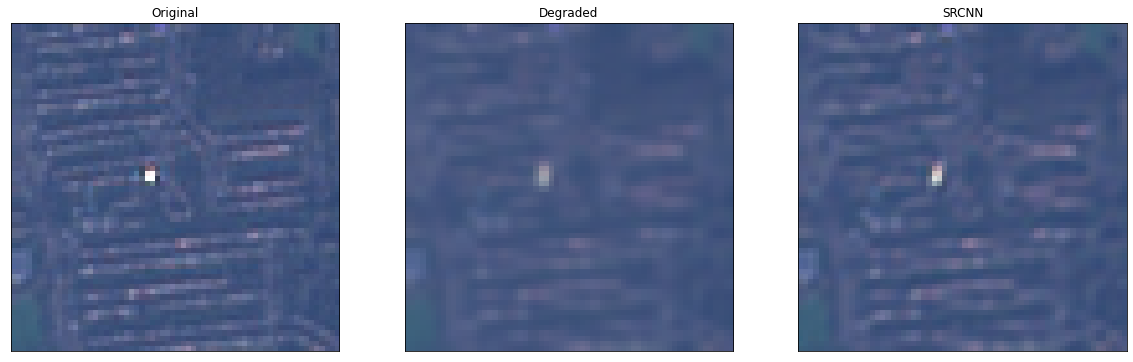

In [26]:
ref, degraded, output, scores = predict(800)

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(ref)
axs[0].set_title('Original')
axs[1].imshow(degraded)
axs[1].set_title('Degraded')
axs[2].imshow(output)
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


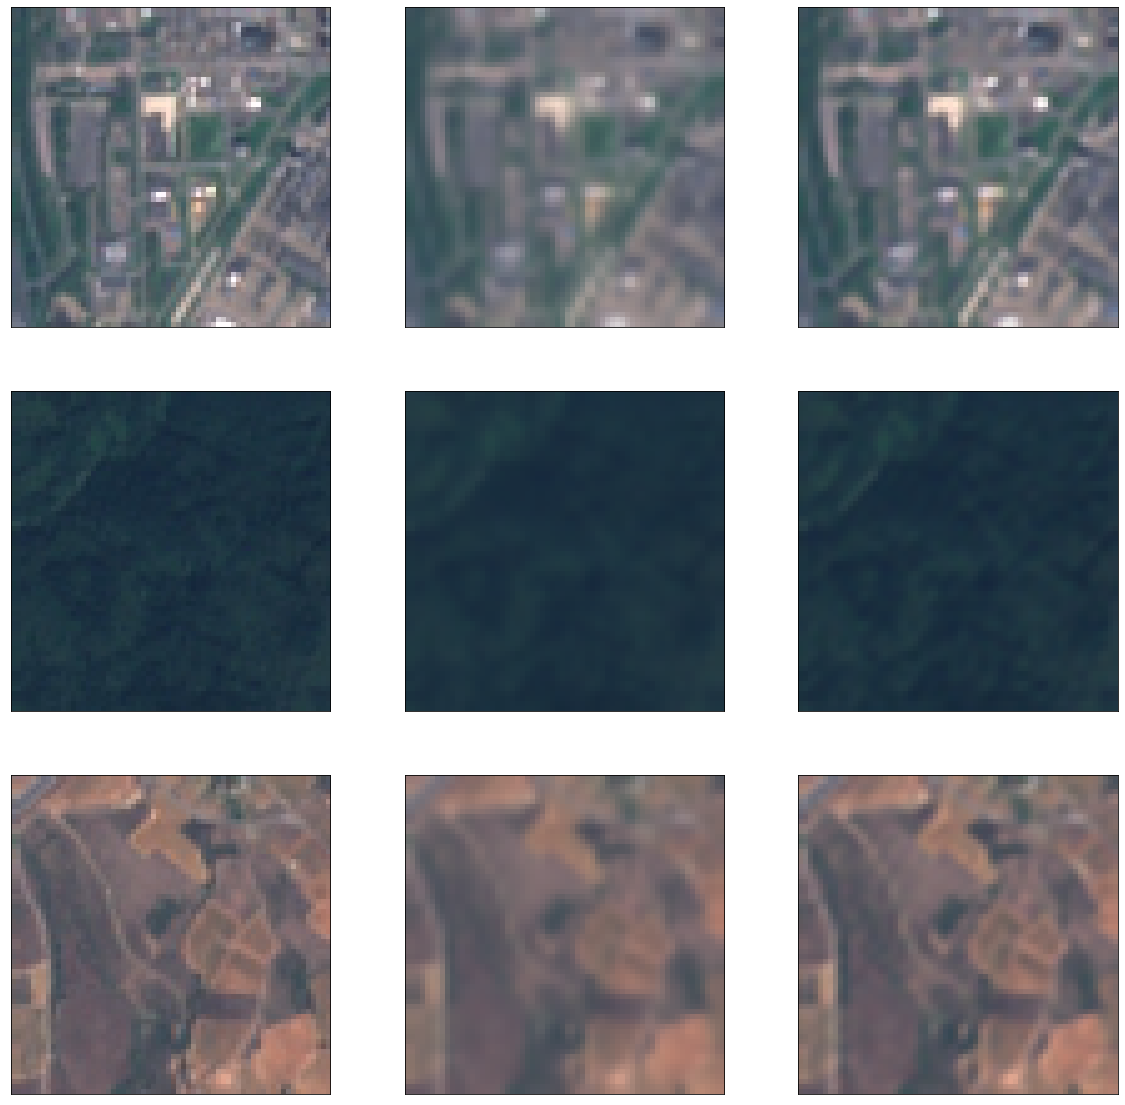

In [27]:
from random import randint
av = len(val_x)
n = 3
fig, axs = plt.subplots(n, 3, figsize=(20, 20))
if n == 1 :
  example = randint(0,av)
  axs[0].imshow(val_x[example])
  axs[0].get_xaxis().set_visible(False)
  axs[0].get_yaxis().set_visible(False)

  axs[1].imshow(val_x_low[example])
  axs[1].get_xaxis().set_visible(False)
  axs[1].get_yaxis().set_visible(False)

  axs[2].imshow(predictions[example])
  axs[2].get_xaxis().set_visible(False)
  axs[2].get_yaxis().set_visible(False)
else :
  for i in range(n):
    example = randint(0,av)
    axs[i][0].imshow(val_x[example])
    axs[i][0].get_xaxis().set_visible(False)
    axs[i][0].get_yaxis().set_visible(False)

    axs[i][1].imshow(val_x_low[example])
    axs[i][1].get_xaxis().set_visible(False)
    axs[i][1].get_yaxis().set_visible(False)


    axs[i][2].imshow(predictions[example])
    axs[i][2].get_xaxis().set_visible(False)

    axs[i][2].get_yaxis().set_visible(False)

plt.show()

In [28]:
def Psnr(im1 , im2 , max_value = 1.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr = tf.image.psnr(im1, im2, max_val= max_value)
  return float(psnr)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def SSIM(im1 , im2 , max_value = 2.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM = tf.image.ssim(im1, im2, max_val= max_value)
  return float(SSIM)

In [29]:
ssim = list(map(SSIM,predictions,val_x_low))
mse = list(map(mse, predictions, val_x_low))
Psnr = list(map(Psnr , predictions , val_x_low))

In [30]:
metrics = pd.DataFrame(list(zip(ssim, Psnr, mse)), 
               columns =['SSIM','PSNR', 'mse' ]) 

In [31]:
metrics.head()

,SSIM,PSNR,mse
0,0.994969,45.541504,0.000084
1,0.999204,53.911381,0.000012
2,0.996145,44.158558,0.000115
3,0.935714,28.880886,0.003882
4,0.983643,39.312473,0.000351


In [32]:
metrics.mean(axis = 0)

SSIM     0.973127
PSNR    39.468772
mse      0.001105
dtype: float64

In [33]:
SRCNN.load_weights('/content/superResolution_checkpoint3.h5')

In [34]:
!mkdir /content/test/

In [35]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Pasture_9.jpg to Pasture_9.jpg
User uploaded file "Pasture_9.jpg" with length 2938 bytes


In [36]:
from skimage.transform import resize
def preprocess_uploaded_test(filepath):
  image = cv2.imread(filepath ,cv2.IMREAD_COLOR)
  HighRes = resize(image, (64, 64))
  # Add this image to the high res dataset
  # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
  LowRes = get_low_res(HighRes , factor = 2)
  return HighRes , LowRes

In [38]:
HR , LR = preprocess_uploaded_test('/content/Pasture_9.jpg')

In [39]:
test_results = predictions = SRCNN.predict(np.reshape(LR,(1,64,64,3)))

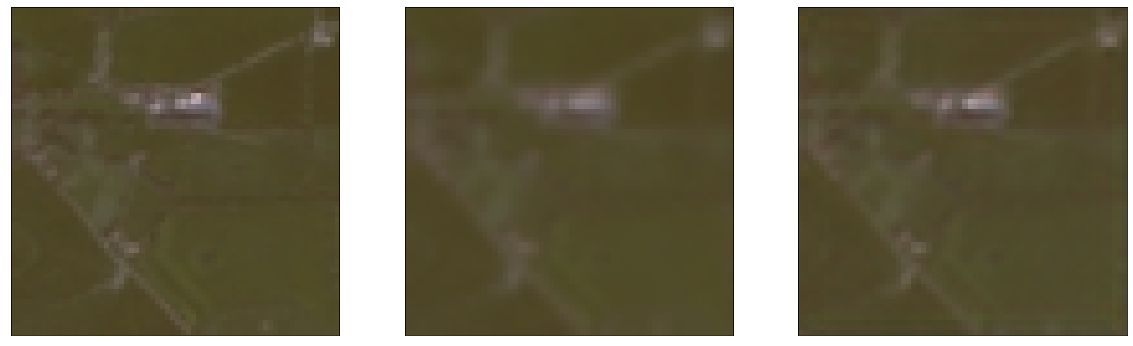

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(HR)
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)

axs[1].imshow(LR)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)

axs[2].imshow(test_results[0])
axs[2].get_xaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)

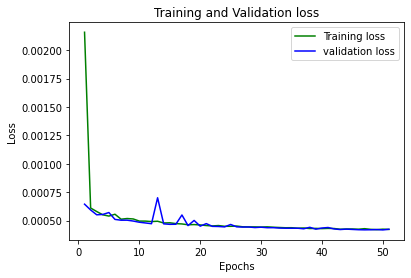

In [43]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,52)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

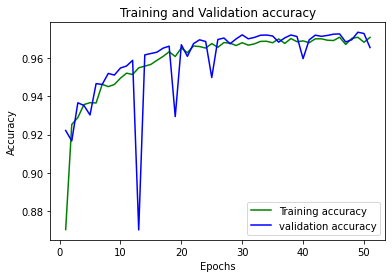

In [44]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,52)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()